In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import prepare as p
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.api import Holt, ExponentialSmoothing

In [2]:
df = pd.read_csv('saas.csv', index_col = 0)
df.head()

,Customer_Id,Invoice_Id,Subscription_Type,Amount
Month_Invoiced,,,,
2014-01-31,1000000,5000000,0.0,0.0
2014-01-31,1000001,5000001,2.0,10.0
2014-01-31,1000002,5000002,0.0,0.0
2014-01-31,1000003,5000003,0.0,0.0
2014-01-31,1000004,5000004,1.0,5.0


In [3]:
df.index

Index(['2014-01-31', '2014-01-31', '2014-01-31', '2014-01-31', '2014-01-31',
       '2014-01-31', '2014-01-31', '2014-01-31', '2014-01-31', '2014-01-31',
       ...
       '2017-12-31', '2017-12-31', '2017-12-31', '2017-12-31', '2017-12-31',
       '2017-12-31', '2017-12-31', '2017-12-31', '2017-12-31', '2017-12-31'],
      dtype='object', name='Month_Invoiced', length=790458)

In [4]:
df = p.date_index(df)
df.head()

/Users/goat/codeup-data-science/time-series-exercises/prepare.py:59: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df.columns = df.columns.str.replace('+', '_')


,customer_id,invoice_id,subscription_type,amount,month,day,year
Month_Invoiced,,,,,,,
2014-01-31,1000000,5000000,0.0,0.0,January,Friday,2014
2014-01-31,1000001,5000001,2.0,10.0,January,Friday,2014
2014-01-31,1000002,5000002,0.0,0.0,January,Friday,2014
2014-01-31,1000003,5000003,0.0,0.0,January,Friday,2014
2014-01-31,1000004,5000004,1.0,5.0,January,Friday,2014


In [5]:
df.index

DatetimeIndex(['2014-01-31', '2014-01-31', '2014-01-31', '2014-01-31',
               '2014-01-31', '2014-01-31', '2014-01-31', '2014-01-31',
               '2014-01-31', '2014-01-31',
               ...
               '2017-12-31', '2017-12-31', '2017-12-31', '2017-12-31',
               '2017-12-31', '2017-12-31', '2017-12-31', '2017-12-31',
               '2017-12-31', '2017-12-31'],
              dtype='datetime64[ns]', name='Month_Invoiced', length=790458, freq=None)

In [6]:
df = df.drop(columns = ['customer_id', 'invoice_id', 'subscription_type', 'month', 'day', 'year'])

In [7]:
#df.asfreq('M')

In [8]:
p.summarize(df)

Shape (790458, 1)
Date Range 2014-01-31 00:00:00 to 2017-12-31 00:00:00

_________________________________________________



Number of rows: 48
Number of days between first and last day: 1431 days 00:00:00

_________________________________________________



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 790458 entries, 2014-01-31 to 2017-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   amount  790458 non-null  float64
dtypes: float64(1)
memory usage: 28.2 MB

_________________________________________________




amount    0
dtype: int64

_________________________________________________




0.0     496410
5.0     178212
10.0     70706
15.0     26474
20.0     18656
Name: amount, dtype: int64

_________________________________________________



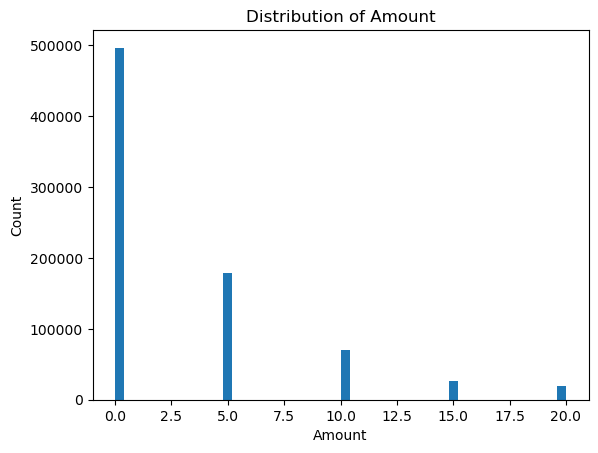

In [9]:
p.plt_dist(df, 'amount', loop = True)

In [10]:
train = df.loc[:'2015']
validate = df.loc['2016']
test = df.loc['2017']

train.shape, validate.shape, test.shape

((431894, 1), (186275, 1), (172289, 1))

In [28]:
month_train = train.resample('m').amount.sum()
month_val = validate.resample('m').amount.sum()
month_test = test.resample('m').amount.sum()

month_train.shape, month_val.shape, month_test.shape

((24,), (12,), (12,))

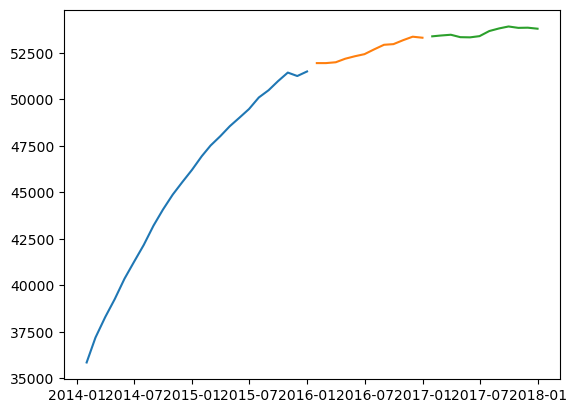

In [12]:
plt.plot(month_train)
plt.plot(month_val)
plt.plot(month_test)
plt.show()

In [13]:
rolling = round(month_train.rolling(6).mean()[-1], 2)
rolling

50965.83

In [22]:
preds = pd.DataFrame({'actual': month_val,
                      'rolling': rolling})

preds.head()

,actual,rolling
Month_Invoiced,,
2016-01-31,51955.0,50965.83
2016-02-29,51955.0,50965.83
2016-03-31,52000.0,50965.83
2016-04-30,52190.0,50965.83
2016-05-31,52325.0,50965.83


In [23]:
def eval_preds(df, predictions, actual='actual'):
    
    return round(sqrt(mean_squared_error(df[actual], df[predictions])), 2)

In [24]:
eval_preds(preds, 'rolling')

1725.98

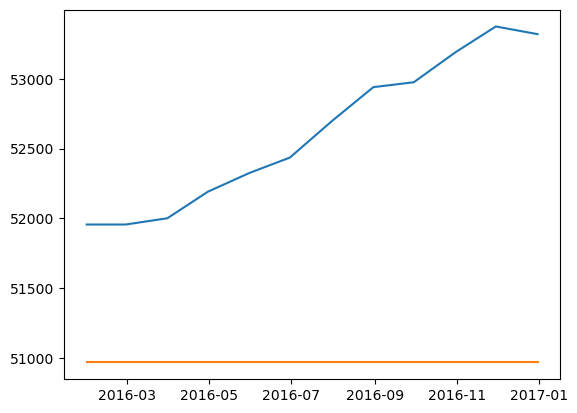

In [25]:
plt.plot(preds['actual'])
plt.plot(preds['rolling'])
plt.show()

In [29]:
hst_model = ExponentialSmoothing(month_train, seasonal_periods=12, trend='add', seasonal='add').fit()

/usr/local/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [31]:
hst_model.forecast(month_val.shape[0])

2016-01-31    50664.578929
2016-02-29    52217.314868
2016-03-31    52551.980836
2016-04-30    52800.671788
2016-05-31    53159.325708
2016-06-30    53441.454745
2016-07-31    53897.409638
2016-08-31    54306.687776
2016-09-30    54712.588430
2016-10-31    55152.791223
2016-11-30    55220.271741
2016-12-31    55487.904875
Freq: M, dtype: float64

In [32]:
preds['hst'] = hst_model.forecast(month_val.shape[0])

In [33]:
eval_preds(preds, 'hst')

1366.59

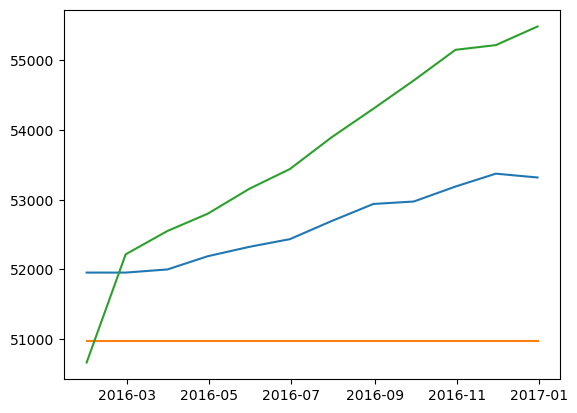

In [34]:
plt.plot(preds['actual'])
plt.plot(preds['rolling'])
plt.plot(preds['hst'])
plt.show()